In [1]:
#Import needed packages

import datetime
import pathlib
import yaml

#from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras

import pickle
from PIL import Image

2022-04-10 15:16:51.444632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-10 15:16:51.444662: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load constantes

In [2]:
with open("config.yaml",'r') as config_file:
    config = yaml.safe_load(config_file)
    IMAGE_WIDTH = config["image_width"]
    IMAGE_HEIGHT = config["image_height"]
    IMAGE_DEPTH = config["image_depth"]
    DATA_DIR= pathlib.Path(config["data_dir"])
    MODELS_DIR = pathlib.Path(config["models_dir"])
    TARGET_NAME= config["target_name"]
    DATA_TRAIN_FILE= config["data_train_file"]
    DATA_TEST_FILE= config["data_test_file"]

# Functions

In [3]:
def load_resize_image(path,height,width):
    """Load an image and resize it to the target size

    Parameters:
    ----------
        path (Path): path to the file to load and resize
        height (int): the height of the final resized image
        width(int): the width of the resized image 
    Return
    ------
    numpy.array containing resized image
    """
    return np.array(Image.open(path).resize((width,height)))

In [4]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str):
    """build x tensor and y tensor for model fitting.
    parameters
    ----------
    df(pd.DataFrame): dataframe 
    target(str): name of target column
    images (str): name of resized images column
        
    Returns
    -------
    x (numpy.array): numpy.array of x values
    y (numpy.array): numpy.array of y values
    """
    
    x= np.array(df[images].to_list())
    y=tf.keras.utils.to_categorical(df[target].astype('category').cat.codes) 
    return x,y

In [5]:
def build_image_database(path,target):
    """    Build a pandas dataframe with target class and access path to images.

    Parameters:
        - path (Path): Path pattern to read csv file containing images information
        - target(str): The second column to extract from the file

    Return:
        A pandas dataframe,
    -------
    """
    #Load file
    _df= pd.read_csv(path,
            names=["all"],
        )
    #Recover data
    _df["image_id"]=_df["all"].apply(lambda x: x.split(' ')[0])
    _df[target]=_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
    _df[target].unique()

    #Create path
    _df["path"]= _df['image_id'].apply( lambda x: DATA_DIR/"images"/(x+'.jpg')) 
    
    return _df.drop(columns=["all"])

In [6]:
def build_classification_model(nbre_classes):
    """Build a tensorflow model using information from target and images columns in dataframes
    Parameters
    ----------
        - df (pandas.dataFrame): dataframe with target and images columns
        - target (str): column name for target variable
        - images (str): column name for images
    Returns
    ------
    tensorflow model built & compiled
    """
    #Initialize a base model base on imagenet
    image_net = keras.applications.Xception(
        weights='imagenet',  
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH),
        include_top=False)
    
    #Freeze all the layers of the model 
    image_net.trainable = False
    
    #Create input layer
    inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH))
    
    #Data augmentation, as the number of images is not a lot
    data_augmentation=keras.Sequential(
        [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),]
    )

    
    x = data_augmentation(inputs)

    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)
    
    x = image_net(x, training=False)
   
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    x = keras.layers.Dropout(0.2)(x) 
    
    #Create output layer
    outputs = keras.layers.Dense(nbre_classes,activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    #Compile the model
    model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalCrossentropy()])

    return model

In [7]:
def show_image(df,row,target):
    """show the image in the ligne row and the associated target column

    Args:
        df (pandas.dataFrame): the dataframe of images
        row (int): the index of the row
        target (string): the column name of the associated label
    Return
    ------
    None
    """
    assert target in df.columns, f"Column {target} not found in dataframe"
    assert 'path' in df.columns, f"Column path doens't not exit in dataframe"
    _img = plt.imread(df.loc[row,'path'])
    plt.imshow(_img)
    return

In [8]:
def classify_images(images,model,classes_names=None):
    """Classify images through a tensorflow model.
    
    Parameters:
    -----------
    images(np.array): set of images to classify
    model (tensorflow.keras.Model): tensorflow/keras model
    
    Returns
    -------
    predicted classes 
    
    """
    results = model.predict(images)
    classes = np.argmax(results,axis=1)
    if classes_names is not None:
        classes = np.array(classes_names[classes])
    return classes

In [9]:
def save_model(model ,saving_dir=MODELS_DIR,basename=TARGET_NAME,append_time=False):
    """Save tf/Keras model in saving_dir folder

    Parameters
    ----------
    model (tf/Keras model): model to be saved
    saving_dir (path): location to save model file
    basename (str): the basename of the model
    append_time (bool): indicate if the time will be append to the basename
    """
    model_name = f"{basename}{'_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') if append_time   else ''}"
    model.save(f"{saving_dir}/learning/{model_name}.h5")
    return model_name

# Read train & test file

In [10]:
train_df = build_image_database(DATA_DIR/DATA_TRAIN_FILE,TARGET_NAME)
test_df = build_image_database(DATA_DIR/DATA_TEST_FILE,TARGET_NAME)

In [11]:
# Previous the dataframe 
train_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,../dataset/data/images/1025794.jpg
1,1340192,Boeing,../dataset/data/images/1340192.jpg
2,0056978,Boeing,../dataset/data/images/0056978.jpg
3,0698580,Boeing,../dataset/data/images/0698580.jpg
4,0450014,Boeing,../dataset/data/images/0450014.jpg


In [12]:
test_df.head()

,image_id,manufacturer,path
0,1514522,Boeing,../dataset/data/images/1514522.jpg
1,0747566,Boeing,../dataset/data/images/0747566.jpg
2,1008575,Boeing,../dataset/data/images/1008575.jpg
3,0717480,Boeing,../dataset/data/images/0717480.jpg
4,0991569,Boeing,../dataset/data/images/0991569.jpg


# View some images

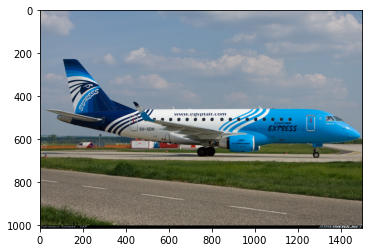

In [13]:
show_image(train_df, np.random.randint(0,train_df.shape[0]), TARGET_NAME)

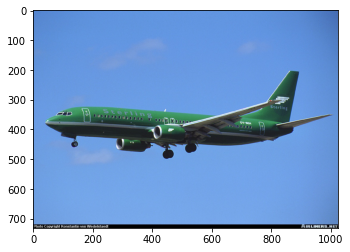

In [14]:
show_image(test_df,np.random.randint(0,test_df.shape[0]),TARGET_NAME)

# Resize Images

In [15]:
#Resize train images
train_df['resized_image'] = train_df.apply(
        lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),
        axis=1)
#Resize test images
test_df['resized_image'] = test_df.apply(
    lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),
    axis=1)

# Split dataset into x and y

In [16]:
X_train,y_train = build_x_and_y(train_df,TARGET_NAME,'resized_image')
X_test,y_test = build_x_and_y(test_df,TARGET_NAME,'resized_image')

In [17]:
classes_names = train_df[TARGET_NAME].astype('category').cat.categories

# Build & train the model

In [18]:
model  = build_classification_model(len(classes_names))
model.summary()

2022-04-10 15:18:38.781950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-10 15:18:38.781989: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 15:18:38.782022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rich-pc): /proc/driver/nvidia/version does not exist
2022-04-10 15:18:38.782287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [19]:
%load_ext tensorboard

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

rm: cannot remove './logs/fit/20220410-145817/train': Directory not empty
rm: cannot remove './logs/fit/20220410-145817/validation': Directory not empty


In [20]:
%%time 
model.fit(X_train,y_train,epochs=5,batch_size = 32,validation_data=(X_test,y_test))

Epoch 1/5


2022-04-10 15:18:40.305877: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163872768 exceeds 10% of free system memory.


105/105 [==============================] - ETA: 0s - loss: 2.8352 - categorical_crossentropy: 2.8352

2022-04-10 15:19:20.195604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163823616 exceeds 10% of free system memory.


105/105 [==============================] - 80s 746ms/step - loss: 2.8352 - categorical_crossentropy: 2.8352 - val_loss: 2.4544 - val_categorical_crossentropy: 2.4544
Epoch 2/5
105/105 [==============================] - 81s 771ms/step - loss: 2.4353 - categorical_crossentropy: 2.4353 - val_loss: 2.3380 - val_categorical_crossentropy: 2.3380
Epoch 3/5
105/105 [==============================] - 80s 764ms/step - loss: 2.2500 - categorical_crossentropy: 2.2500 - val_loss: 2.3406 - val_categorical_crossentropy: 2.3406
Epoch 4/5
105/105 [==============================] - 80s 763ms/step - loss: 2.1662 - categorical_crossentropy: 2.1662 - val_loss: 2.1897 - val_categorical_crossentropy: 2.1897
Epoch 5/5
105/105 [==============================] - 80s 762ms/step - loss: 2.1093 - categorical_crossentropy: 2.1093 - val_loss: 2.1482 - val_categorical_crossentropy: 2.1482
CPU times: user 32min 29s, sys: 1min 32s, total: 34min 1s
Wall time: 6min 39s


In [21]:
%tensorboard  --logdir  logs/fit 

Reusing TensorBoard on port 6006 (pid 41993), started 0:19:48 ago. (Use '!kill 41993' to kill it.)

# Evaluation of the model

In [22]:
classify_images(X_test[10:20],model,classes_names)

array(['Airbus', 'Boeing', 'McDonnell Douglas', 'Boeing', 'Airbus',
       'Boeing', 'Boeing', 'Boeing', 'Canadair', 'McDonnell Douglas'],
      dtype=object)

In [23]:
#Compute accuracy of the model
transfert_learning_prediction = model.predict(X_test).argmax(axis=1)
transfert_learning_accuracy = np.mean( 
    y_test.argmax(axis=1)==transfert_learning_prediction
)
transfert_learning_accuracy

2022-04-10 15:25:21.142788: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163823616 exceeds 10% of free system memory.


0.33993399339933994

# Save the model

In [24]:
model_name = save_model(model,MODELS_DIR)

In [25]:
with open(MODELS_DIR/"classes"/f"{model_name}.yaml","w") as classe_file:
    yaml.dump(list(classes_names),classe_file)

# Compare Transfert with SVM and Neural network

In [26]:
#Compute accuracy for svm
with open(MODELS_DIR/f"svms/{model_name}.h5","rb") as file:
    svm_model = pickle.load(file)
    X_svm_test = np.array(test_df.apply(lambda row: np.ndarray.flatten(row["resized_image"]),axis=1).to_list())
    _predicted_classe = svm_model.predict(X_svm_test).astype(int)
    svm_accuracy = np.mean(_predicted_classe==y_test.argmax(axis=1))
    svm_accuracy

/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [27]:
neural_model = tf.keras.models.load_model(MODELS_DIR/f"neural_networks/{model_name}.h5")
x= np.array(test_df["resized_image"].to_list())
neural_prediction = neural_model.predict(x).argmax(axis=1)
neural_accuracy = np.mean(y_test.argmax(axis=1)==neural_prediction)
neural_accuracy

2022-04-10 15:28:19.099854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 163823616 exceeds 10% of free system memory.


0.21992199219921993

In [28]:
print(f"""
======Accuracy=====
Neural network: {round(neural_accuracy,2)},
SVC: {round(svm_accuracy,2)},
Transfert learning: {round(transfert_learning_accuracy,2)}
""")


======Accuracy=====
Neural network: 0.22,
SVC: 0.29,
Transfert learning: 0.34

